In [1]:
import main
from main import StepResult, ElasticData, CalculationResult, print_history, run_lammps
import network
import matplotlib.pyplot as plt
import convert
import os
import lammps_scripts

In [ ]:
os.chdir("/home/sergey/work/auxetic_optimizer/")
lj_sim = lammps_scripts.LJSimulation(
    n_atoms=200,
    n_atom_types=4,
    atom_sizes=[1.8, 1.5, 1.2, 0.9],
    box_dim=[-40, 40, -40, 40, -0.1, 0.1],
    temperature_range=lammps_scripts.TemperatureRange(
        T_start=1e-3, T_end=1e-6, bias=10.0),
    iso_p=0.2,
    p_damp=10.0,
    n_steps=10000
)

lj_sim.write_to_file("/home/sergey/work/auxetic_optimizer/highZ")
# run_lammps("/home/sergey/work/auxetic_optimizer/highZ", input_file="lammps.in")
run_lammps(
    "/home/sergey/work/auxetic_optimizer/highZ",
    input_file="in.elastic")
# ex = network.Network.from_atoms("/home/sergey/work/auxetic_optimizer/highZ/coord.dat", include_default_masses=1e6, include_angles=False)
# ex.write_to_file("/home/sergey/work/auxetic_optimizer/highZ/network.lmp")
# print(ex.coordination_number)


In [2]:
def plot_opt_history(log_dir: str, log_file:str = "optimization_log.pkl"):
    opt_history = main.load_optimization_log(os.path.join(log_dir, log_file))
    steps = [i+1 for i in range(len(opt_history))]
    Bs = [step.dG.bulk_modulus for step in opt_history]
    Gs = [step.dG.shear_modulus for step in opt_history]
    Ps = [step.dG.p_ratio for step in opt_history]
    Zs = [step.network.coordination_number for step in opt_history]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    axs[0].plot(Zs, Ps, label='P')
    axs[0].set_ylabel("Poisson's ratio")
    axs[0].set_xlabel("Z")
    axs[0].legend()
    # P ratio graph
    # axs[1].plot(steps, Ps, label='P')
    # axs[1].set_xlabel("Step")
    # axs[1].legend()
    # Moduli graph
    axs[1].plot(Zs, Bs, label='B')
    axs[1].plot(Zs, Gs, label='G')
    axs[1].set_ylabel("Moduli")
    axs[1].set_xlabel("Z")
    axs[1].legend()
    plt.show()

    return opt_history

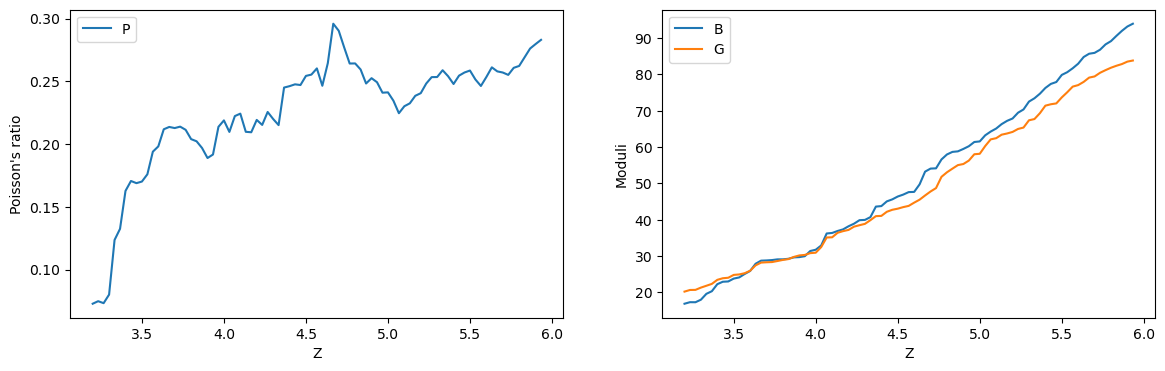

Elastic data: P: 0.073, B = 16.887, G = 20.224

In [16]:
# history = plot_opt_history("/home/sergey/work/auxetic_optimizer/successful_cases/", log_file="small_auxetic_0.01.pkl")
history = plot_opt_history("/home/sergey/work/auxetic_optimizer/networks/60/0")
# old_network = history[0].network
# old_network.write_to_file("/home/sergey/work/auxetic_optimizer/successful_cases/step0_0.01.lmp")


In [ ]:
# opt_dir = "/home/sergey/python/simulator_data_gen/data/raw/networks/90/0"
opt_dir = "networks/80/0"

opt_history = main.load_optimization_log(os.path.join(opt_dir, "optimization_log.pkl"))
# opt_history = main.load_optimization_log(os.path.join(opt_dir, "small_auxetic.pkl"))

steps = [i+1 for i in range(len(opt_history))]
Bs = [step.dG.bulk_modulus for step in opt_history]
Gs = [step.dG.shear_modulus for step in opt_history]
Ps = [step.dG.p_ratio for step in opt_history]
Zs = [step.network.coordination_number for step in opt_history]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
# P ratio graph
axs[0].plot(Zs, Ps, label='P')
axs[0].set_ylabel("Poisson's ratio")
axs[0].set_xlabel("Z")
axs[0].legend()
# P ratio graph
axs[1].plot(steps, Ps, label='P')
axs[1].set_xlabel("Step")
axs[1].legend()
# Moduli graph
axs[2].plot(Zs, Bs, label='B')
axs[2].plot(Zs, Gs, label='G')
axs[2].set_ylabel("Moduli")
axs[2].set_xlabel("Z")
axs[2].legend()

plt.show()
